In [1]:
from IPython.display import Audio
import random
import matplotlib.pyplot as plt
import tempfile
import numpy as np
import pandas as pd
import os

In [2]:
import torch
from torch import optim
from torch.nn.functional import cross_entropy
import torchaudio
import torchaudio.transforms as T
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [3]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, classification_report

In [4]:
import ray
from ray import tune
from ray import train
from ray.train import Checkpoint
from ray.tune.search.optuna import OptunaSearch
from ray.tune.schedulers import ASHAScheduler
from ray.train import RunConfig
from ray.tune import CLIReporter

In [5]:
from src.custom_audio_dataset import CustomAudioDataset
from src.utils import pad_collate_fn, plot_spectrogram, dataloader_from_filter
from src.datasets import get_data_path
from src import custom_layers, models
from src.hesitation import coraa_filters

In [6]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

MAX_EPOCH = 15

TRAIN_SIZE = 0.6
TEST_FROM_VAL_SIZE = 0.5

SAMPLE_RATE = 16_000
MAX_SECONDS_DURATION = 10

MAX_FEATURES_IN = SAMPLE_RATE * MAX_SECONDS_DURATION

DEVICE

'cuda'

In [7]:
annotations_file_path, data_dir_path = get_data_path("hesitation_dev")
annotations_file_path, data_dir_path

('/home/glucas11/projects/repos/speech_feedback/temp_datasets/hesitation_dev/annotations.csv',
 '/home/glucas11/projects/repos/speech_feedback/temp_datasets/hesitation_dev')

In [8]:
filters_func = {
    "filter0": coraa_filters.filter0,
    "filter1": coraa_filters.filter1,
    "filter2": coraa_filters.filter2,
}

models_arch = {
    "CnnMFCC": models.CnnMFCC,
    "CnnMFCC_v2": models.CnnMFCC_v2,
    "CnnSpectrogram": models.CnnSpectrogram,
}

In [9]:
def train_func(model, optimizer, dataloader):
	model.train()
	losses = []
	pred_np = []
	target_np = []
	for batch_idx, (data, target) in enumerate(dataloader):
		optimizer.zero_grad()
		data, target = data.to(DEVICE), target.to(DEVICE)
		logits = model(data)
		loss = cross_entropy(logits, target)
		losses.append(loss.item())
		loss.backward()
		optimizer.step()
		
		preds = torch.max(logits, dim=1).indices
		pred_np.append(preds.detach().cpu().numpy())
		target_np.append(target.detach().cpu().numpy())
	
	pred_np = np.concatenate(pred_np)
	target_np = np.concatenate(target_np)

	return {
		"mean_loss": sum(losses) / len(losses),
		"accuracy": accuracy_score(target_np, pred_np),
		"f1_score": f1_score(target_np, pred_np),
		# "confusion_matrix": confusion_matrix(target_np, pred_np),
	}

def validate_func(model, dataloader):
	model.eval()
	
	losses = []
	pred_np = []
	target_np = []
	with torch.no_grad():
		for batch_idx, (data, target) in enumerate(dataloader):
			data, target = data.to(DEVICE), target.to(DEVICE)
			logits = model(data)
			loss = cross_entropy(logits, target)
			losses.append(loss.item())
			
			preds = torch.max(logits, dim=1).indices
			pred_np.append(preds.detach().cpu().numpy())
			target_np.append(target.detach().cpu().numpy())

	pred_np = np.concatenate(pred_np)
	target_np = np.concatenate(target_np)

	return {
		"mean_loss": sum(losses) / len(losses),
		"accuracy": accuracy_score(target_np, pred_np),
		"f1_score": f1_score(target_np, pred_np),
	}

In [10]:
def train_hesitation(config:dict, max_epochs=30, tunning=True):
	features_in = config['max_seconds_length'] * SAMPLE_RATE
	train_data_transform = torch.nn.Sequential(
    # custom_layers.RandomPitchShiftLayer(p=0.001, sample_rate=SAMPLE_RATE, min_steps=-5, max_steps=5), # too heavy
    # custom_layers.ReverberationLayer(1,400), # not working yet
    custom_layers.PadOrTruncateLayer(features_in),
    custom_layers.NoiseLayer(p=0.5, noise_factor=0.05),
	)
	data_transform = torch.nn.Sequential(
		custom_layers.PadOrTruncateLayer(features_in),
	)
	filter_func = filters_func[config["coraa_filter_func"]]
	train_dataloader, val_dataloader, test_dataloader = dataloader_from_filter(
		annotations_file_path=annotations_file_path,
		data_dir_path=data_dir_path,
		filter=filter_func,
		target_column_name="has_hesitation",
		train_data_transform=train_data_transform,
		data_transform=data_transform,
		train_size=0.6,
		test_from_val_size=0.5
	)
	model_architecture = models_arch[config['model_architecture']]
	model = model_architecture(n_classes=2, sample_rate=SAMPLE_RATE, features_in=features_in, dropout=config['dropout'])
	model = model.to(DEVICE)

	optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])

	# early_stopping_patience = 5  # Number of epochs to wait before stopping
	scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.7, patience=3)
	for i in range(max_epochs):
		train_log = train_func(model, optimizer, train_dataloader)
		val_log = validate_func(model, val_dataloader)
		
		scheduler.step(val_log['mean_loss'])

		if tunning:
			with tempfile.TemporaryDirectory() as temp_checkpoint_dir:
				checkpoint = None
				if (i + 1) % max_epochs == 0 and (val_log["mean_loss"] < 0.4):
					# This saves the model to the trial directory
					torch.save(
						model.state_dict(),
						os.path.join(temp_checkpoint_dir, "model.pth")
					)
					checkpoint = Checkpoint.from_directory(temp_checkpoint_dir)

				# Send the current training result back to Tune
				train.report(
					{
						"train_mean_loss": train_log["mean_loss"],
						"train_accuracy": train_log["accuracy"],
						"train_f1_score": train_log["f1_score"],
						"val_mean_loss": val_log["mean_loss"],
						"val_accuracy": val_log["accuracy"],
						"val_f1_score": val_log["f1_score"],
					},
					checkpoint=checkpoint
				)
		else:
			print("-"*10, f"epoch: {i+1}/{max_epochs}","-"*10)
			print(f"train: {train_log}\nval: {val_log}")
	if not tunning:
		return {
			"model": model,
			"test_dataloader": test_dataloader,
		}
	test_log = validate_func(model, test_dataloader)
	print(test_log)
	train.report(
		{
			"test_mean_loss": test_log["mean_loss"],
			"test_accuracy": test_log["accuracy"],
			"test_f1_score": test_log["f1_score"],
		},
		checkpoint=checkpoint
	)

In [11]:
max_cpus = os.cpu_count()
max_gpus = torch.cuda.device_count()
max_cpus, max_gpus

config = {
    "max_seconds_length": tune.randint(3, 20),
    "dropout": tune.uniform(0.1, 0.5),
    "coraa_filter_func": tune.choice(filters_func.keys()),
    "learning_rate":  tune.loguniform(1e-5, 1e-2),
	"weight_decay": tune.loguniform(1e-5, 1e-2),
    "model_architecture": tune.choice(models_arch.keys()),
}

metric = "val_mean_loss"
mode = "min"

optuna_search = OptunaSearch(
	metric=metric,
	mode=mode,
	# points_to_evaluate = curr_best_params,
)

asas_scheduler = ASHAScheduler(
	time_attr='training_iteration',
	metric=metric,
	mode=mode,
	max_t=30,
	grace_period=10,
	reduction_factor=3,
	brackets=2
)


In [12]:
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_rows', None)     # Show all rows
pd.set_option('display.max_colwidth', None)   # No limit on column width
pd.set_option('display.width', 1000)        # Set the display width to a large number

In [13]:
trainable_with_resources = tune.with_resources(train_hesitation, {"cpu": max_cpus, "gpu": max_gpus})

tuner = tune.Tuner(
	trainable_with_resources,
	tune_config=tune.TuneConfig(
		num_samples=50,
		search_alg=optuna_search,
		scheduler=asas_scheduler
	),
	param_space=config,
)
results = tuner.fit()

2024-09-03 13:22:28,862	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/home/glucas11/ray_results/train_hesitation_2024-09-03_13-10-46' in 0.0093s.
2024-09-03 13:22:28,877	INFO tune.py:1041 -- Total run time: 699.65 seconds (699.60 seconds for the tuning loop).


In [14]:
results.get_dataframe().to_csv("raytune_results.csv")

<Axes: title={'center': 'f1_score hist'}, ylabel='Frequency'>

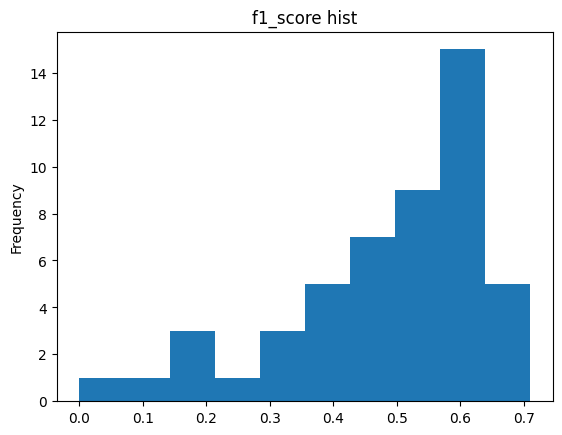

In [15]:
df_results = results.get_dataframe()
df_results['val_f1_score'].plot(kind='hist', title='f1_score hist')

<Axes: title={'center': 'val loss hist'}, ylabel='Frequency'>

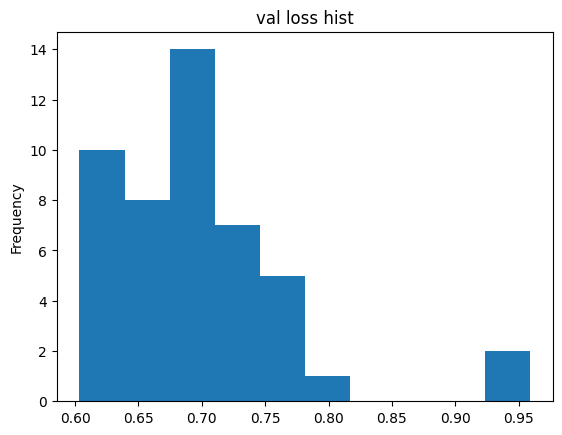

In [16]:
df_results[df_results['val_mean_loss'] < 1]['val_mean_loss'].plot(kind='hist', title='val loss hist')

<Axes: title={'center': 'accuracy hist'}, ylabel='Frequency'>

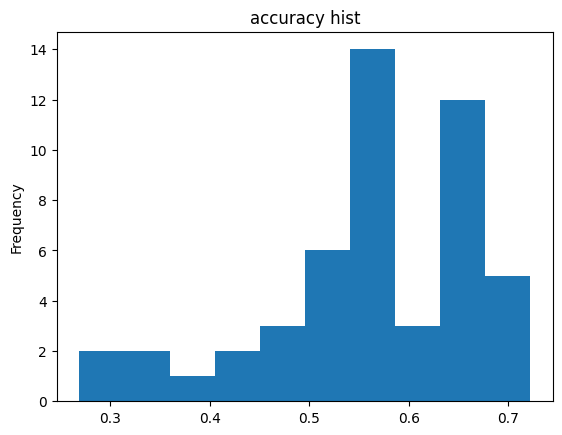

In [17]:
df_results['val_accuracy'].plot(kind='hist', title='accuracy hist')

<Axes: title={'center': 'train loss hist'}, ylabel='Frequency'>

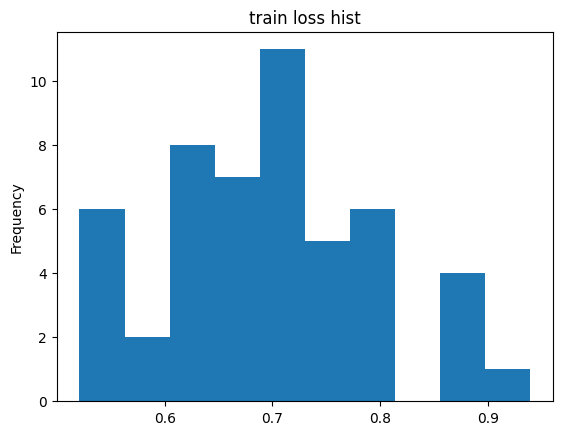

In [18]:
df_results[df_results['train_mean_loss'] < 1]['train_mean_loss'].plot(kind='hist', title='train loss hist')

In [19]:
best_result = results.get_best_result("val_f1_score", mode="max")
best_config = best_result.metrics['config']
print(best_config)
best_train = train_hesitation(best_config, max_epochs=30, tunning=False)
model = best_train["model"]

{'max_seconds_length': 15, 'dropout': 0.19252144841596175, 'coraa_filter_func': 'filter1', 'learning_rate': 0.0011024850246353784, 'weight_decay': 0.0008707303314739007, 'model_architecture': 'CnnMFCC_v2'}
---------- epoch: 1/30 ----------
train: {'mean_loss': 0.9070492453045316, 'accuracy': 0.45774647887323944, 'f1_score': np.float64(0.45390070921985815)}
val: {'mean_loss': 0.9369895855585734, 'accuracy': 0.45263157894736844, 'f1_score': np.float64(0.0)}
---------- epoch: 2/30 ----------
train: {'mean_loss': 0.8347700834274292, 'accuracy': 0.5246478873239436, 'f1_score': np.float64(0.466403162055336)}
val: {'mean_loss': 0.710673451423645, 'accuracy': 0.5789473684210527, 'f1_score': np.float64(0.5918367346938775)}
---------- epoch: 3/30 ----------
train: {'mean_loss': 0.70952265130149, 'accuracy': 0.5845070422535211, 'f1_score': np.float64(0.48695652173913045)}
val: {'mean_loss': 0.7312018871307373, 'accuracy': 0.5368421052631579, 'f1_score': np.float64(0.5111111111111111)}
---------- 

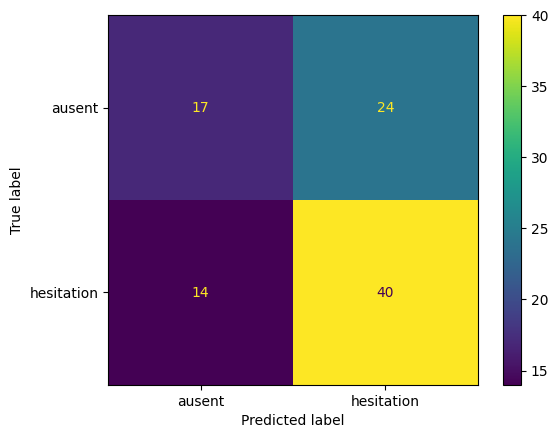



              precision    recall  f1-score   support

      ausent       0.55      0.41      0.47        41
  hesitation       0.62      0.74      0.68        54

    accuracy                           0.60        95
   macro avg       0.59      0.58      0.58        95
weighted avg       0.59      0.60      0.59        95


accuracy: 0.6

f1_score: 0.6779661016949152


In [20]:
model.eval()
losses = []
pred_np = []
target_np = []
with torch.no_grad():
	for batch_idx, (data, target) in enumerate(best_train['test_dataloader']):
		data, target = data.to(DEVICE), target.to(DEVICE)
		logits = model(data)
		loss = cross_entropy(logits, target)
		losses.append(loss.item())
		
		preds = torch.max(logits, dim=1).indices
		pred_np.append(preds.detach().cpu().numpy())
		target_np.append(target.detach().cpu().numpy())

pred_np = np.concatenate(pred_np)
target_np = np.concatenate(target_np)

classes_names = ['ausent', 'hesitation']

cm = confusion_matrix(target_np, pred_np)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes_names)
disp.plot()
plt.show()
print("\n")
print(classification_report(target_np, pred_np, target_names=classes_names))
print("\naccuracy:", accuracy_score(target_np, pred_np))
print("\nf1_score:", f1_score(target_np, pred_np))